In [2]:
import dicom
import os
import numpy
from scipy.misc import imresize
from sklearn.preprocessing import scale
from itertools import filterfalse
# from skimage.io import imread, imsave
import matplotlib.path as mplPath
import json
import pickle
from sklearn.preprocessing import scale 
# from skimage import exposure 
from skimage.draw import polygon
from support.dcmx import DICOMReader
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Extract DCM

In [2]:
DICOM_PATH = '/home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/'
dim = 32

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

from six.moves import xrange
import tensorflow as tf

In [23]:
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 10000

In [39]:
def _generate_image_and_label_batch(image, min_queue_examples,
                                    batch_size, shuffle, n_threads=16):
    """Construct a queued batch of images and labels.

    Args:
    image: 3-D Tensor of [height, width, 3] of type.float32.
    label: 1-D Tensor of type.int32
    min_queue_examples: int32, minimum number of samples to retain
      in the queue that provides of batches of examples.
    batch_size: Number of images per batch.
    shuffle: boolean indicating whether to use a shuffling queue.

    Returns:
    images: Images. 4D tensor of [batch_size, height, width, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.
    """
    # Create a queue that shuffles the examples, and then
    # read 'batch_size' images + labels from the example queue.
    if shuffle:
        images, label_batch = tf.train.shuffle_batch(
            [image, image],
            batch_size=batch_size,
            num_threads=n_threads,
            capacity=min_queue_examples + 3 * batch_size,
            min_after_dequeue=min_queue_examples)
    else:
        images, label_batch = tf.train.batch(
            [image, image],
            batch_size=batch_size,
            num_threads=n_threads,
            capacity=min_queue_examples + 3 * batch_size)

    # Display the training images in the visualizer.
    tf.image_summary('images', images)
    print(label_batch)
    print(images)
    return images, tf.reshape(label_batch, [batch_size])

In [40]:
def distorted_inputs(read_input, num_examples_per_epoch, patch_size, batch_size):
    """Construct distorted input for CIFAR training using the Reader ops.

    Args:
    data_dir: Path to the CIFAR-10 data directory.
    batch_size: Number of images per batch.

    Returns:
    images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.
    """

    reshaped_image = tf.cast(read_input, tf.float32)

    # Image processing for training the network. Note the many random
    # distortions applied to the image.

    # Randomly crop a [height, width] section of the image.
    # distorted_image = tf.random_crop(reshaped_image, [height, width, 1])

    # Randomly flip the image horizontally.
    distorted_image = tf.image.random_flip_left_right(reshaped_image)

    # Because these operations are not commutative, consider randomizing
    # the order their operation.
    
    distorted_image = tf.image.random_brightness(distorted_image,
                                               max_delta=63)
    
    distorted_image = tf.image.random_contrast(distorted_image,
                                             lower=0.2, upper=1.8)

    # Subtract off the mean and divide by the variance of the pixels.
    float_image = tf.image.per_image_whitening(distorted_image)

    # Set the shapes of tensors.
    float_image.set_shape([patch_size, patch_size, 1])

    # Ensure that the random shuffling has good mixing properties.
    min_fraction_of_examples_in_queue = 0.4
    min_queue_examples = int(num_examples_per_epoch *
                           min_fraction_of_examples_in_queue)
    print ('Filling queue with %d input images before starting to train. '
           'This will take a few minutes.' % min_queue_examples)

    # Generate a batch of images and labels by building up a queue of examples.
    return _generate_image_and_label_batch(float_image,
                                         min_queue_examples, batch_size,
                                         shuffle=True)


In [10]:
dr = DICOMReader()
images, masks = dr.extract_data(start=0, end=10, PathDicom=DICOM_PATH)

images = [im for im, ms in zip(images, masks) if ms.sum()]
masks = [ms for ms in masks if ms.sum()]

images = [imresize(i, (400,400), "bicubic") for i in images]
masks = [imresize(i, (400,400), "bicubic") for i in masks]
# images = [exposure.equalize_adapthist(tmp) for tmp in images]
images = [tmp / (-1.) for tmp in images]
images = [scale(tmp.astype(float), axis=0).astype('float32') for tmp in images]
images = [(tmp + abs(tmp.min())) / (tmp.max() + abs(tmp.min()))  for tmp in images]

patches = dr.cut_on_patches(images, masks=masks, patch_size=dim)

/home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/
<generator object walk at 0x7f70e4aaa3b8>
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image001.dcm  0
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image002.dcm  1
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image003.dcm  2
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image004.dcm  3
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image005.dcm  4
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image006.dcm  5
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image007.dcm  6
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image008.dcm  7
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image009.dcm  8
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image010.dcm  9
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image001.json  0
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDisp

## Test and save

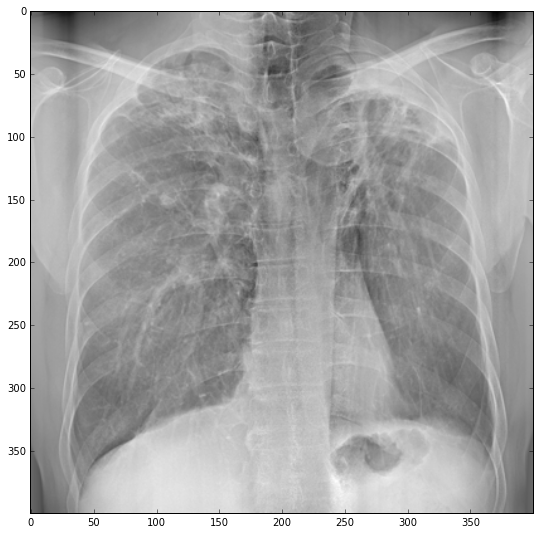

In [11]:
pyplot.figure(figsize=(9,9))
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.imshow(images[6]) # + masks[0])

train = random.permutation(train)
pickle.dump(patches, open('./patches.pkl', 'wb'))

# Convolutional Auto-Encoder

In [18]:
import tensorflow as tf

## Load Patches

In [4]:
patches = pickle.load(open('./patches.pkl', 'rb'))

In [6]:

test = asarray(patches[:2])
train = asarray(patches[2:])

## Build Model

In [7]:
from skimage.util import random_noise 

noise_factor = 1
train_noisy = asarray([random_noise(img, 'gaussian', var=0.005, clip=False) for img in train]).reshape(-1, dim, dim, 1)
test_noisy = asarray([random_noise(img, 'gaussian', var=0.005, clip=False) for img in test]).reshape(-1, dim, dim, 1)
# train_noisy = np.asarray([random_noise(flatten(img), 's&p', amount=0.1, clip=False) for img in train])
# test_noisy = np.asarray([random_noise(flatten(img), 's&p', amount=0.1, clip=False) for img in test])

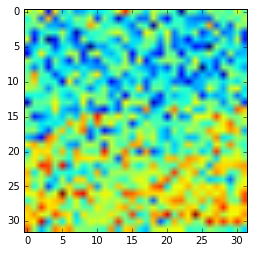

In [8]:
plt.imshow(test_noisy[1][:, :, 0])

In [ ]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Deconvolution2D, Flatten, Reshape
from keras.models import Model
from keras.optimizers import SGD 

input_img = Input(shape=(1, dim, dim))

x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
encoded = MaxPooling2D((2, 2), border_mode='same')(x)

# at this point the representation is (8, 4, 4) i.e. 128-dimensional

x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(16, 3, 3, activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)


In [ ]:
input_img = Input(shape=(dim, dim, 1))
encoded = Flatten()(input_img)
encoded = Dense(228, activation='relu')(encoded)
encoded = Dense(164, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)

decoded = Dense(164, activation='relu')(encoded)
decoded = Dense(228, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
decoded = Reshape(target_shape=(28, 28, 1))(decoded)

In [27]:
from keras.callbacks import TensorBoard

# autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder = Model(input_img, decoded)
sgd = SGD(lr=0.05, momentum=0.9, nesterov=True)
autoencoder.compile(loss='mean_squared_error', optimizer=sgd)

In [88]:
autoencoder.load_weights('./denoise_autoencoder_dense_X_weights')
encoder.load_weights('./denoise_encoder_dense_X_weights')

In [28]:
encoder = Model(input=input_img, output=encoded)

In [62]:
from keras.callbacks import EarlyStopping
esr = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
for i in range(10):
    pickle.dump(array(i), open('./counter', 'wb'))
    autoencoder.fit(train_noisy, train, 
                    nb_epoch=250,
                    batch_size=232,
                    callbacks=[esr],
                    shuffle=True,
                    validation_data=(test_noisy, test))
    autoencoder.save('./denoise_autoencoder_conv_X')
    encoder.save('./denoise_encoder_conv_X')
    autoencoder.save_weights('./denoise_autoencoder_conv_X_weights')
    encoder.save_weights('./denoise_encoder_conv_X_weights')

Train on 160926 samples, validate on 2000 samples
Epoch 1/250
 32480/160926 [=====>........................] - ETA: 11s - loss: 8.8893e-04

KeyboardInterrupt: 

In [61]:
decoded_imgs = autoencoder.predict(test)

In [60]:
print(pickle.load(open('./counter', 'rb')))

3


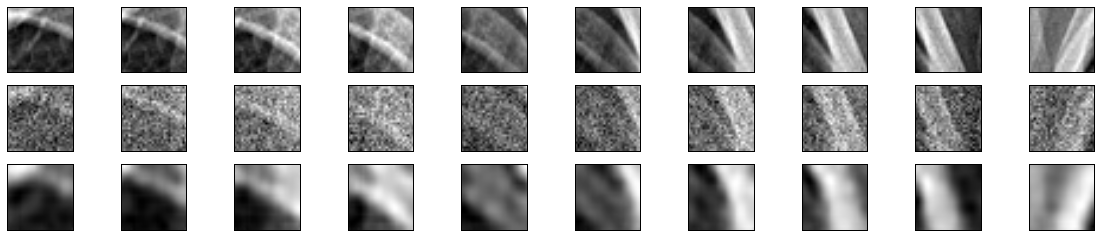

In [64]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(500, 500 + n):
    # display original
    ax = plt.subplot(3, n, i+1 - 500)
    plt.imshow(test[i].reshape(dim, dim))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original
    ax = plt.subplot(3, n, i+1 + n + - 500)
    plt.imshow(test_noisy[i].reshape(dim, dim))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i +  2 * n + 1 - 500)
    plt.imshow(decoded_imgs[i].reshape(dim, dim) )
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [65]:
autoencoder.save('./denoise_autoencoder_dense_X')
encoder.save('./denoise_encoder_dense_X')
autoencoder.save_weights('./denoise_autoencoder_dense_X_weights')
encoder.save_weights('./denoise_encoder_dense_X_weights')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# decoded_imgs = autoencoder.predict(test)

n = 3
plt.figure(figsize=(5, 5))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_noisy[i].reshape(dim, dim))
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test[i].reshape(dim, dim))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
plt.figure(figsize=(5, 5))
for i in range(n):
    # display reconstruction
    ax = plt.subplot(2, n, i+1)
    plt.imshow(decoded_imgs[i].reshape(31, 31))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [44]:
weights = [] 
for layer in autoencoder.layers:
    weights += [layer.get_weights()]

kernels = []
for weight in weights:
    if len(weight) != 0:
        for kernel in weight:
             kernels += [kernel]

In [46]:
shape(kernels[0])

(3, 3, 1, 16)

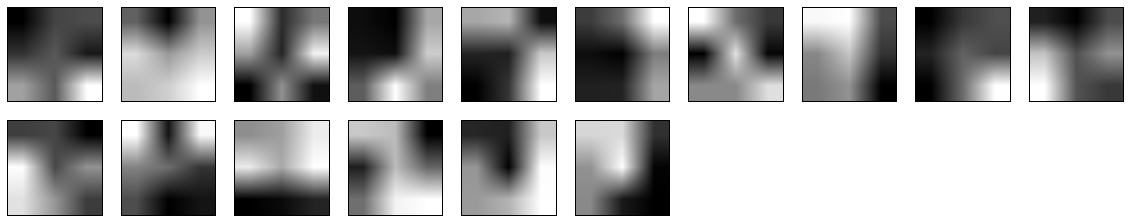

(3, 3, 1, 16)

In [51]:
figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(10, 10, i + 1)
    imshow(kernels[0][:, :, 0, i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
show()
shape(kernels[0])

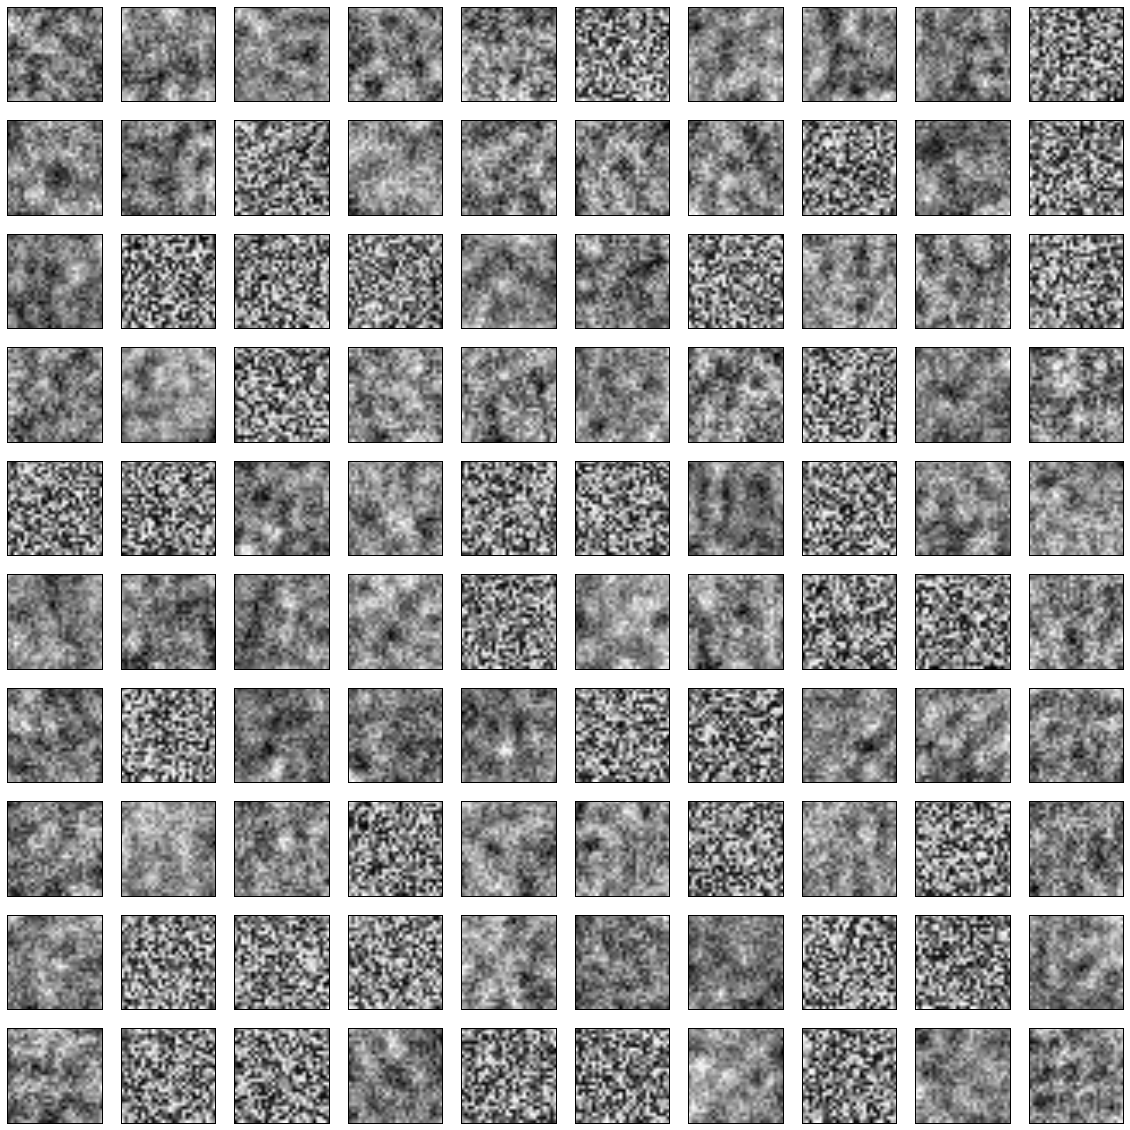

(784, 228)

In [77]:
figure(figsize=(20, 20))
for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    imshow(kernels[-2][i, :].reshape((dim, dim)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
show()
shape(kernels[0])